# **Generative Adversarial Network (GAN)**

Generative Adversarial Networks, or GANs, are a deep-learning-based generative model. More generally, GANs are a model architecture for training a generative model such as deep CNNs for generating images, and it is most common to use deep learning models in this architecture.

**Why use GANs?**

Because GANs are a brilliant method of training a generative model by framing the problem as supervised learning with two sub-models: the Generator model that we train to generate new examples, and the Discriminator model that tries to classify examples as either real (from the dataset) or fake (i.e. generated).



**Generator.** The model that is used to generate new plausible examples from the problem domain.
The generator model takes a fixed-length random vector as input and generates a sample in the domain.
`After training, the generator model is kept and used to generate new samples.`
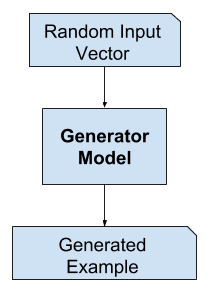


**Discriminator.** The model that is used to classify examples as real (from the domain) or fake (generated). The discriminator model takes an example from the domain as input (real or generated) and predicts a binary class label of real or fake (generated)\. The real example comes from the training dataset. The generated examples are output by the generator model. The discriminator is a normal (and well understood) classification model. `After the training process, the discriminator model is discarded as we are interested in the generator.`
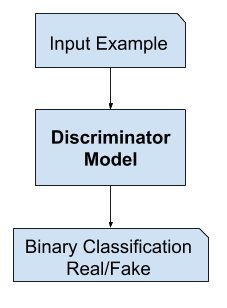



`The two models, the generator and discriminator, are trained together.` The generator generates a batch of samples, and these, along with real examples from the domain, are provided to the discriminator and classified as real or fake.

The discriminator is then updated to get better at discriminating real and fake samples in the next round, and importantly, the generator is updated based on how well, or not, the generated samples fooled the discriminator.

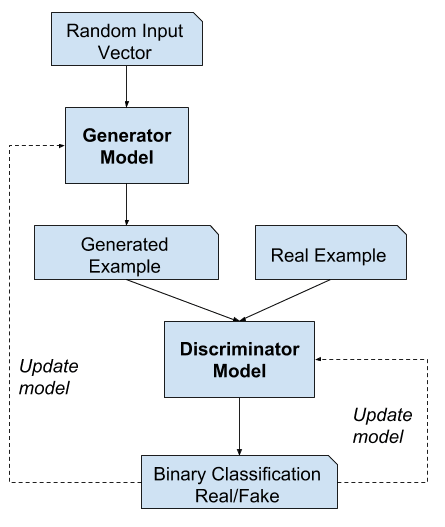


For this project we will implement a `DCGAN - Deep Convolutional Generative Adversarial Network-` in TensorFlow on [Anime faces dataset](https://www.kaggle.com/datasets/splcher/animefacedataset).

# Import libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import glob
import PIL
import imageio
import os

# Data

Download images data from [Kaggle](https://www.kaggle.com/datasets/splcher/animefacedataset)

In [1]:
anime_data_dir = "animefacedataset/"

In [3]:
train_images = tf.keras.utils.image_dataset_from_directory(
    anime_data_dir, label_mode=None, image_size=(64, 64), batch_size=128
)

Found 63565 files belonging to 1 classes.


# Visualization

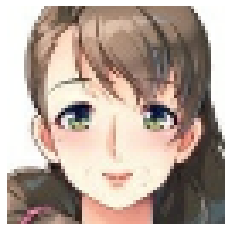

In [4]:
image_batch = next(iter(train_images))
random_index = np.random.choice(image_batch.shape[0])
random_image = image_batch[random_index].numpy().astype("int32")

# Visualize 1 random image from the training dataset
plt.axis("off")
plt.imshow(random_image)
plt.show()

In [5]:
# Helper function to show multiple images
def show(images):
    plt.figure(figsize=(4, 4))

    for i in range(16):
        plt.subplot(4, 4, i+1)
        img = tf.keras.utils.array_to_img(images[i]) 
        plt.imshow(img)
        plt.axis('off') 
    plt.show()

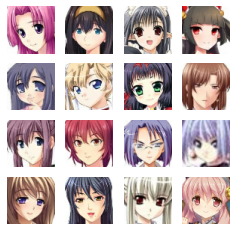

In [6]:
# Visualize 16 images from the training dataset
show(image_batch[:16])

# Preprocessing

In [7]:
# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = train_images.map(lambda x: (x - 127.5) / 127.5)

# The Generator

The generator takes the random noise in the latent vector and maps it to the data space. As we are using RGB images, so our data-space means creating an RGB image.

The generator starts with a dense or fully-connected layer. After that, it is followed the series of transpose convolution, batch normalization and the leaky relu activation function.

At the last, we use a convolution layer with three filters and tanh activation function to generate the RGB image.

In [8]:
# weight initializer for G per DCGAN paper 
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# target output dimensions
IMG_H = 64
IMG_W = 64
IMG_C = 3  # 1 for gray scale and 3 for color images


## Helper functions

In [9]:
def deconv_block(inputs, num_filters, kernel_size, strides, bn=True):
    x = Conv2DTranspose(
        filters=num_filters,
        kernel_size=kernel_size,
        kernel_initializer=WEIGHT_INIT,
        padding="same",
        strides=strides,
        use_bias=False
    )(inputs)
 
    if bn:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
    return x



def conv_block(inputs, num_filters, kernel_size, padding="same", strides=2, activation=True):
    x = Conv2D(
        filters=num_filters,
        kernel_size=kernel_size,
        kernel_initializer=WEIGHT_INIT,
        padding=padding,
        strides=strides,
    )(inputs)
    if activation:
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.3)(x)
    return x

In [10]:
def build_generator(latent_dim):
    f = [2**i for i in range(5)][::-1]
    filters = 32
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides


    # buld generator network
    noise = Input(shape=(latent_dim,), name="generator_noise_input")
    x = Dense(f[0] * filters * h_output * w_output, use_bias=False)(noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((h_output, w_output, 16 * filters))(x)
    for i in range(1, 5):
        x = deconv_block(x,
            num_filters=f[i] * filters,
            kernel_size=5,
            strides=2,
            bn=True
        )
    x = conv_block(x,
        num_filters=3,
        kernel_size=5,
        strides=1,
        activation=False
    )
    fake_output = Activation("tanh")(x)
    
    return Model(noise, fake_output, name="generator")

In [11]:
# build the generator model
generator = build_generator(latent_dim=128) 

In [12]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_noise_input (Inpu  [(None, 128)]            0         
 tLayer)                                                         
                                                                 
 dense (Dense)               (None, 8192)              1048576   
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        32

# The Discriminator

The discriminator is a simple binary classification network that takes both the real and the fake image and outputs a probability of whether the given image is real or fake.

For this purpose, a series strided-convolution is used with leaky relu and the dropout with 0.3. At the last, we flatten the feature maps and use a fully-connected layer with 1 unit. Next, we apply a sigmoid activation function to the fully connected layer.

In [13]:
def build_discriminator():
    f = [2**i for i in range(4)]
    image_input = Input(shape=(IMG_H, IMG_W, IMG_C))    
    x = image_input
    filters = 64
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides
    for i in range(0, 4):
        x = conv_block(x, num_filters=f[i] * filters, kernel_size=5, strides=2)
    x = Flatten()(x)
    x = Dense(1)(x)
    return Model(image_input, x, name="discriminator")

In [14]:
# build the discriminator model
discriminator = build_discriminator() 

In [15]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)     

# Complete DCGAN Moel

The GAN class denotes the complete DCGAN model with the training step defined in it. It takes the discriminator model, generator mode and the loss function. The loss function used here is binary cross-entropy.

The train_step function is used for training the DCGAN model. The training starts with the discriminator. The discriminator is first trained on the fake images generated by the generator. After that it is trained on the real images from the anime faces dataset. Next, the generator is trained based on how well the discriminator is trained.

In [16]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim


    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn


    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for _ in range(2):
            ## Generate fake images
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            generated_images = self.generator(random_latent_vectors)
            
            ## Train the discriminator on fake images
            generated_labels = tf.zeros((batch_size, 1))
            with tf.GradientTape() as ftape:
                predictions = self.discriminator(generated_images)
                d1_loss = self.loss_fn(generated_labels, predictions)
            grads = ftape.gradient(d1_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
            
            ## Train the discriminator on real images
            labels = tf.ones((batch_size, 1))
            with tf.GradientTape() as rtape:
                predictions = self.discriminator(real_images)
                d2_loss = self.loss_fn(labels, predictions)
            grads = rtape.gradient(d2_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

            ## Train the generator
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            misleading_labels = tf.ones((batch_size, 1))
            with tf.GradientTape() as gtape:
                predictions = self.discriminator(self.generator(random_latent_vectors))
                g_loss = self.loss_fn(misleading_labels, predictions)
            grads = gtape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
            
            return {"d1_loss": d1_loss, "d2_loss": d2_loss, "g_loss": g_loss}

## Callback to monitor training

In [17]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=25, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during traing
        self.seed = tf.random.normal([self.num_img, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        n = int(np.sqrt(self.num_img))
        fig = plt.figure(figsize=(n, n))
        for i in range(self.num_img):
            plt.subplot(n, n, i+1)
            img = tf.keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img)
            plt.axis('off')
        if not os.path.exists("samples/"):
          os.makedirs("samples/")
        filename = "samples/generated_plot_epoch_{:04d}.png".format(epoch)
        plt.savefig(filename) 
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save("saved_model/g_model.h5")
        self.model.discriminator.save("saved_model/d_model.h5")


# Saving images

In [18]:
def save_plot(examples, epoch, n):
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        plt.subplot(n, n, i+1)
        plt.axis("off")
        plt.imshow(examples[i])
    if not os.path.exists("samples/"):
        os.makedirs("samples/")
    filename = "samples/generated_plot_epoch_{:04d}.png".format(epoch)
    
    plt.savefig(filename)
    plt.close()

# Run the code

In [19]:
if __name__ == "__main__":
    ## Hyperparameters
    batch_size = 128 # Reminder for the paremeter used when loading dataset 
    latent_dim = 128
    num_epochs = 20
    
    # Normalize the images to [-1, 1] which is the range of the tanh activation
    train_images = train_images.map(lambda x: (x - 127.5) / 127.5)
    
    # Build models
    d_model = build_discriminator()
    g_model = build_generator(latent_dim)
    # d_model.load_weights("saved_model/d_model.h5")
    # g_model.load_weights("saved_model/g_model.h5")
    d_model.summary()
    g_model.summary()
    
    
    gan = GAN(d_model, g_model, latent_dim)
    bce_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)
    d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    gan.compile(d_optimizer, g_optimizer, bce_loss_fn)
    
    for epoch in range(num_epochs):
        gan.fit(train_images, epochs=1)
        g_model.save("saved_model/g_model.h5")
        d_model.save("saved_model/d_model.h5")
        n_samples = 25
        noise = np.random.normal(size=(n_samples, latent_dim))
        examples = g_model.predict(noise)
        save_plot(examples, epoch, int(np.sqrt(n_samples)))

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 128)     

KeyboardInterrupt: 

# Créer un GIF

In [22]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('samples/generated_plot_epoch_{:04d}.png'.format(epoch_no))

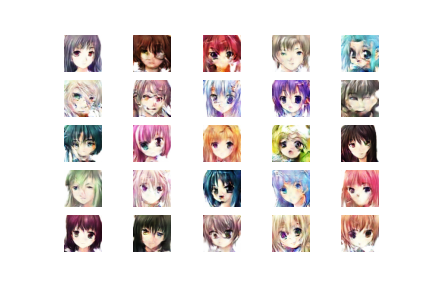

In [25]:
display_image(num_epochs-1)

In [40]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('samples/generated*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

['samples/generated_plot_epoch_0008.png', 'samples/generated_plot_epoch_0017.png', 'samples/generated_plot_epoch_0006.png', 'samples/generated_plot_epoch_0016.png', 'samples/generated_plot_epoch_0019.png', 'samples/generated_plot_epoch_0011.png', 'samples/generated_plot_epoch_0001.png', 'samples/generated_plot_epoch_0007.png', 'samples/generated_plot_epoch_0013.png', 'samples/generated_plot_epoch_0004.png', 'samples/generated_plot_epoch_0012.png', 'samples/generated_plot_epoch_0014.png', 'samples/generated_plot_epoch_0018.png', 'samples/generated_plot_epoch_0002.png', 'samples/generated_plot_epoch_0009.png', 'samples/generated_plot_epoch_0003.png', 'samples/generated_plot_epoch_0000.png', 'samples/generated_plot_epoch_0005.png', 'samples/generated_plot_epoch_0015.png', 'samples/generated_plot_epoch_0010.png']


In [41]:
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ek_c3syl
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ek_c3syl
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179891 sha256=89c9c60721cbeb23f007843717e3af6dd50532a2b0fa756e2b7229e8087ab8c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-ynnzfo2b/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs



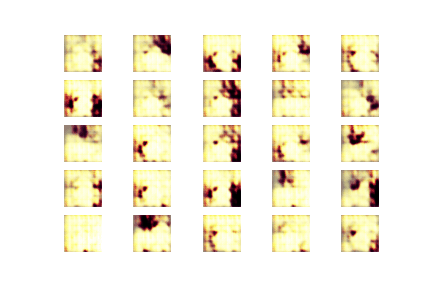

In [42]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)